In [115]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os.path
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
import dvu
dvu.set_style()
from collections import defaultdict
import imodelsx.process_results
results_dir = '../results/classification'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/02_classification.py'
r = imodelsx.process_results.fill_missing_args_with_default(
    r, experiment_filename)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 10/10 [00:00<00:00, 548.93it/s]


In [116]:
r.columns

Index(['label_name', 'input_text', 'seed', 'save_dir', 'model_name',
       'use_cache', 'save_dir_unique', 'macro_precision', 'macro_recall',
       'macro_f1-score', 'accuracy', 'roc_auc', 'mean_macro_precision',
       'mean_macro_recall', 'mean_macro_f1-score', 'mean_accuracy',
       'mean_roc_auc'],
      dtype='object')

In [117]:
df = r.groupby(by=['label_name', 'model_name', 'input_text'])[['mean_macro_precision',
                                                               'mean_macro_recall', 'mean_macro_f1-score', 'mean_accuracy']].mean()
# df.style.format(precision=2).background_gradient(cmap='Blues')
# imodelsx.process_results.delete_runs_in_dataframe(r[r.model_name == 'aug-linear'], actually_delete=True)

In [118]:
d.columns

Index(['label_name', 'model_name', 'input_text', 'mean_macro_precision',
       'mean_macro_recall', 'mean_macro_f1-score', 'legend'],
      dtype='object')

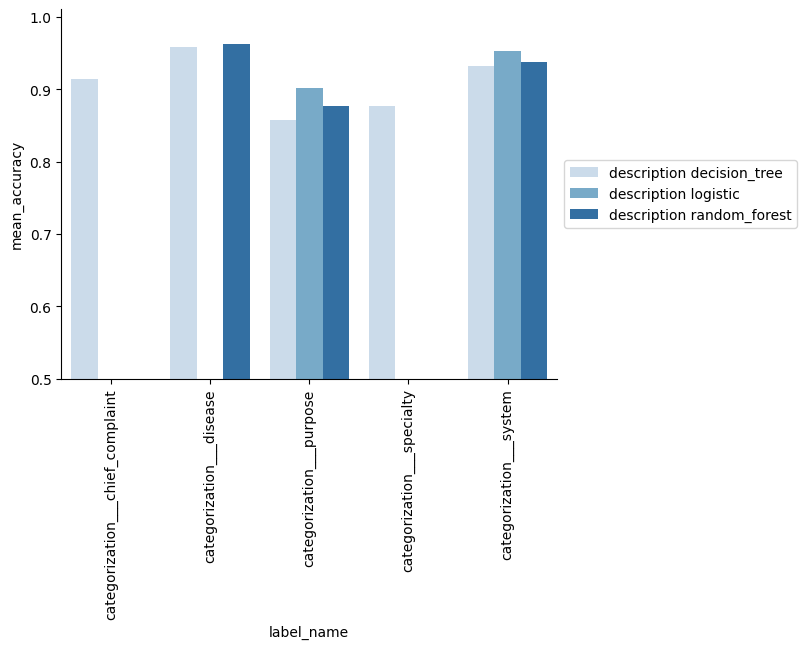

In [119]:
# rotate xticklabels
d = df.reset_index()
d['legend'] = d['input_text'] + ' ' + d['model_name']
ax = sns.barplot(data=d, x='label_name',
                 y='mean_accuracy', hue='legend', palette='Blues', hue_order=sorted(d['legend'].unique()))
plt.xticks(rotation=90)
plt.ylim(bottom=0.5)
# legend to right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [120]:
classification = __import__('02_classification')

In [ ]:
X, y, classes, le = classification.get_classification_data()

In [ ]:
X[0]

In [ ]:
y.sum(axis=0)

In [ ]:
clf = MultiLabelZeroShotGPTClassifier(
    max_labels=5, openai_model="gpt-4-0314")
clf.fit(None, [classes.tolist()])

In [ ]:
labels = clf.predict(X[0:2])

In [ ]:
labels

In [102]:
le.transform(labels)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [109]:
from sklearn.metrics import classification_report, accuracy_score

In [110]:
cls_report = classification_report(
    y[:2], le.transform(labels), output_dict=True, zero_division=0
)

In [111]:
accuracy_score(y[:2], le.transform(labels))

0.0

In [114]:
np.mean(y[:2] == le.transform(labels))

0.9482758620689655

In [ ]:
X[0:2]

In [ ]:
labels